In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import lightkurve as lk
import tglc
import numpy as np

import os
from tglc.quick_lc import tglc_lc
import pickle

from scipy import ndimage
from skimage.measure import label

import matplotlib as mpl

mpl.rcParams['font.size']=15          #10 
mpl.rcParams['savefig.dpi']= 300             #72 
mpl.rcParams['xtick.major.size']= 10           
mpl.rcParams['ytick.major.size']= 10
mpl.rcParams['xtick.minor.size']= 5           
mpl.rcParams['ytick.minor.size']= 5   
mpl.rcParams["errorbar.capsize"]= 5
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['savefig.facecolor'] = 'white'

/opt/anaconda3/envs/AstroStats/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/opt/anaconda3/envs/AstroStats/lib/python3.12/site-packages/tglc/ffi.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
hdul = fits.open('data/original_hon_catalog.fit')
data = hdul[1].data
table = Table(data)
mh = table.to_pandas()
hdul.close()
#mh.sort_values(by='numax')
tics = mh['TIC'].values

mh[mh['numax']>50].head(50)

,TIC,numax,e_numax,Tmag,Teff,e_Teff,Rstar,e_Rstar,Lstar,e_Lstar,Dist,e_Dist,RUWE,Flag,_RA,_DE
5,9423,53.2,7.9,10.2,4857,97,7.5,0.3,28.1,1.2,0.763,0.009,1.19,1,219.109102,-26.222231
43,68772,50.4,2.8,6.9,4592,91,9.2,0.4,33.7,1.0,0.184,0.001,1.05,1,221.032249,-28.352902
53,76443,61.8,4.1,8.0,4816,96,10.6,0.5,54.4,1.9,0.377,0.003,1.13,1,221.339266,-27.207567
56,82359,58.8,3.1,8.5,4739,94,7.7,0.3,27.2,1.0,0.323,0.003,1.63,1,221.423682,-24.980738
62,86927,54.0,8.9,9.8,4565,91,8.9,0.4,30.6,1.4,0.646,0.009,1.32,1,221.614088,-29.349369
70,95154,85.7,9.4,8.1,4888,97,6.5,0.3,21.9,0.7,0.242,0.002,1.62,1,221.800616,-28.315619
76,108200,60.5,3.7,9.6,4625,92,7.9,0.3,25.4,0.9,0.510,0.004,1.09,1,222.296291,-26.600691
114,155128,85.8,15.4,7.9,4932,98,7.1,0.3,27.1,0.9,0.250,0.001,0.85,1,223.521405,-25.209552
116,158617,55.0,4.7,8.9,4788,95,7.9,0.3,29.5,1.0,0.420,0.003,1.17,1,223.742985,-27.549870
136,607984,50.4,3.3,9.5,4695,93,9.7,0.4,41.0,1.6,0.679,0.005,1.09,1,72.137809,-28.198048


Initialize the TIC ID and run TGLC

In [56]:
i = 1
tic = tics[i]

In [57]:
target = f'TIC {tic}'
local_directory = f'tglc_outputs/{target}/'    # directory to save all files
os.makedirs(local_directory, exist_ok=True)
tglc_lc(target=target, local_directory=local_directory, size=90, save_aper=True, limit_mag=15, get_all_lc=False,
        first_sector_only=True, last_sector_only=False, sector=None, prior=None, transient=None)

Target: TIC 1408
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0011-1-4     11      1   4
tess-s0038-1-4     38      1   4
Only processing the first sector the target is observed in: Sector 11.
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0011-1-4     11      1   4
tess-s0038-1-4     38      1   4
Loaded ffi_cut from directory. 
Already in sector 11.
Loaded ePSF TIC 1408 from directory. 


Fitting lc: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


Read in data generated by TGLC to obtain the FFI and PSF cutouts

sector = 11


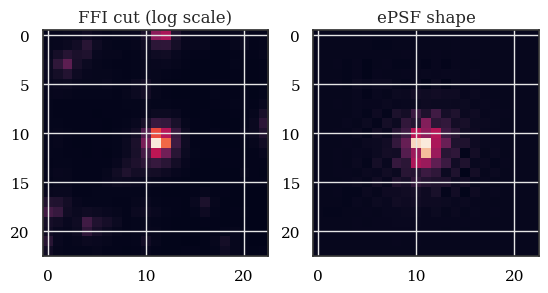

6222999658731597568


In [58]:
with open(f'{local_directory}source/source_{target}_sector_11.pkl', 'rb') as input_:
    source = pickle.load(input_)
    print(f'sector = {source.sector}')
epsf = np.load(f'{local_directory}epsf/epsf_{target}_sector_11.npy')

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.log10(source.flux[0,34:57,34:57]))
ax1.set_title('FFI cut (log scale)')
ax2.imshow(epsf[0,:23**2].reshape(23,23))
ax2.set_title('ePSF shape')
plt.show()

mask = source.tic['TIC'] == tic
#target_row = source.tic

target_gaiadr3_source = source.tic[mask]['dr3_source_id'].value
print(target_gaiadr3_source[0])

Create contamination plot in case it is needed later

In [59]:
#%matplotlib inline
from tglc.quick_lc import plot_contamination
plot_contamination(local_directory=local_directory, gaia_dr3=target_gaiadr3_source[0],ymin=None,ymax=None,pm_years=3000)

Already in sector 11.
Interquartile Range (IQR): 0.0004451860289894083
Standard Deviation: 0.0004053472780482238


show epsf and ffi images

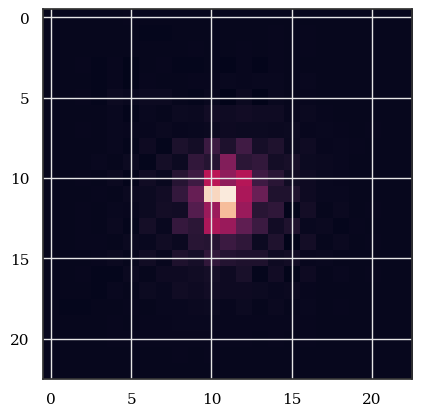

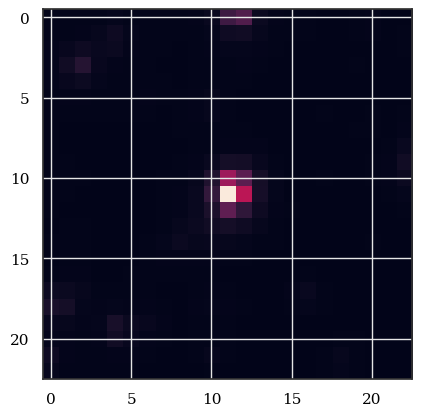

In [60]:
epsf_images = epsf[:, :23**2].reshape(-1, 23, 23)
ffi_images = source.flux[:,34:57,34:57]
plt.imshow(epsf_images[0])
plt.show()
plt.imshow(ffi_images[0])
plt.show()

In [139]:
from sklearn.preprocessing import StandardScaler

# aperture_sequence has shape (t, n_pixels)
# example: n_pixels = 23**2
timestep = 0   # choose which time step to format
n = int(np.sqrt(epsf.shape[1]))  # infer image size (e.g., 23)


# Take the per-pixel median over time for both and weight
median_ffi = np.nanmedian(ffi_images, axis=0)
median_psf = np.nanmedian(epsf_images, axis=0)
weighted_median_flux = median_ffi #np.nanmedian(ffi_images * epsf_images, axis=0)

# Create x, y coordinate grids
y, x = np.indices(weighted_median_flux.shape)  # both shape (n, n)

# Flatten everything and stack into columns
X = np.column_stack([x.flatten(), y.flatten(), median_psf.flatten()/max(median_psf.flatten())])
X2 = np.column_stack([x.flatten(), y.flatten(), weighted_median_flux.flatten()])

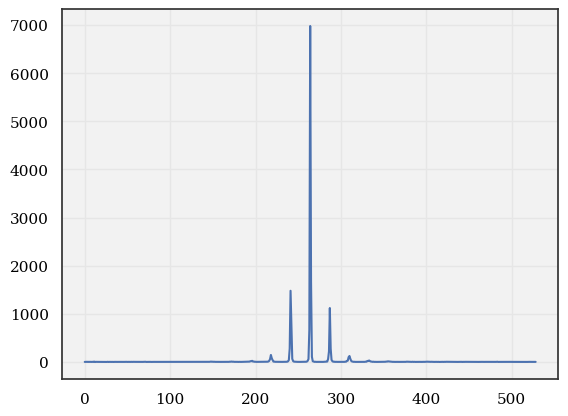

In [143]:
plt.plot(X2[:,2]*X[:,2])
#plt.plot(X[:,2], alpha=0.5)


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clusterer = HDBSCAN(allow_single_cluster=True, min_cluster_size=4, min_samples=3)#, max_cluster_size=25)
fit = clusterer.fit(X_scaled)
labels = fit.labels_

# Count how many stars per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

-1    106
 0    423
Name: count, dtype: int64


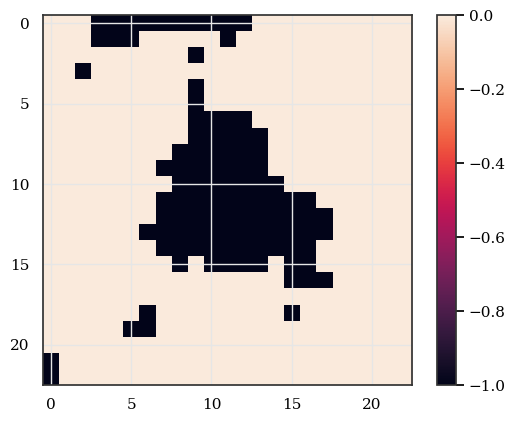

In [118]:
plt.imshow(labels.reshape(n,n))
plt.colorbar()

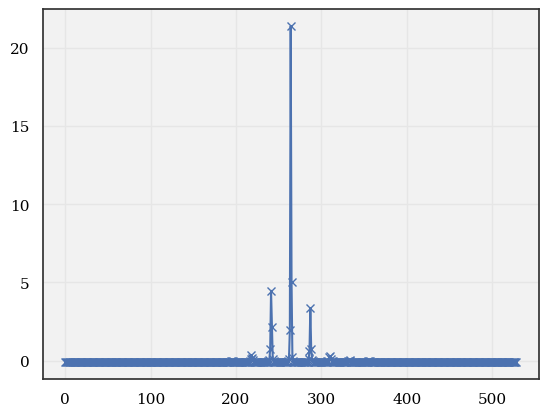

In [119]:
plt.plot(X_scaled[:,2], marker='x')

In [2]:
def filter_connected_pixels(cluster_mask):
    """Keep only the largest connected component from a cluster"""
    # Label connected components (4-connectivity by default)
    labeled_array, num_features = label(cluster_mask, connectivity=1, return_num=True)
    
    if num_features == 0:
        return cluster_mask
    
    # Find the largest connected component
    component_sizes = np.bincount(labeled_array.ravel())[1:]  # Skip background (0)
    largest_component = np.argmax(component_sizes) + 1
    
    # Return mask with only the largest connected component
    return labeled_array == largest_component

In [3]:
# Assuming `labels` is a 1D array of cluster assignments (same size as weighted_flux.flatten())
# and `weighted_flux` is your 2D flux image (e.g., 23x23)

# Find the index of the central pixel
ny, nx = weighted_median_flux.shape
center_idx = (ny // 2) * nx + (nx // 2)

# Get the label of the central pixel
central_label = labels[center_idx]

# Create a mask for that cluster (True where the cluster matches the central pixel’s label)
mask = (labels == central_label).reshape(weighted_median_flux.shape)

new_mask = filter_connected_pixels(mask)

# --- Visualization ---
fig, ax = plt.subplots(figsize=(6, 6))

# Show PSF image as background
im = ax.imshow(weighted_median_flux, cmap='viridis', alpha=0.9)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Overlay hollow red squares for aperture pixels
for y, x in zip(*np.where(new_mask)):
    rect = patches.Rectangle(
        (x - 0.5, y - 0.5),  # lower-left corner
        1, 1,                # width, height
        linewidth=1.5,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.set_title("Weighted HDBSCAN Aperture Overlay", fontsize=14)
ax.set_xlabel("X Pixel")
ax.set_ylabel("Y Pixel")
plt.show()

NameError: name 'weighted_median_flux' is not defined

In [144]:
light_curve = np.sum(epsf_images[:, mask], axis=1)

In [145]:
light_curve

array([139068.16543265, 141812.60813211, 142291.47622813, ...,
       128909.28923139, 128868.57730065, 128915.56865895], shape=(1248,))

Filename: tglc_outputs/TIC 1408//lc/hlsp_tglc_tess_ffi_gaiaid-6222999658731597568-s0011-cam1-ccd4_tess_v2_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 1248)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   1248R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   


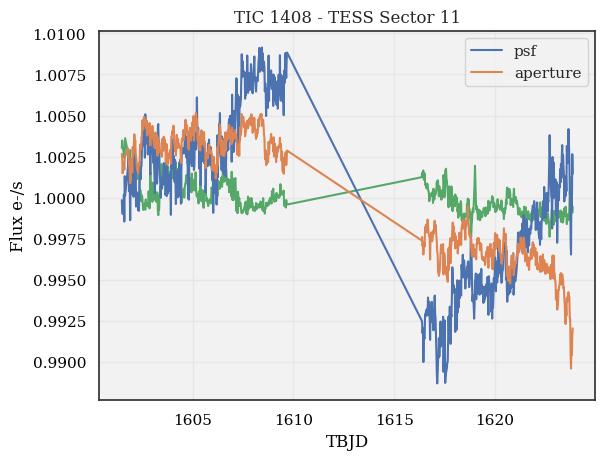

In [277]:
from astropy.io import fits
hdul_s007 = fits.open(f'{local_directory}/lc/hlsp_tglc_tess_ffi_gaiaid-{target_gaiadr3_source[0]}-s0011-cam1-ccd4_tess_v2_llc.fits')
hdul_s007.info()
q_07 = [a and b for a, b in zip(list(hdul_s007[1].data['TESS_flags'] == 0),
                                list(hdul_s007[1].data['TGLC_flags'] == 0))]
# filter out bad datapoints from both TESS FFI flags and TGLC flags

time_07 = hdul_s007[1].data['time'][q_07]
psf_flux_07 = hdul_s007[1].data['psf_flux'][q_07] # raw psf flux
psf_flux_err_07 = hdul_s007[1].header['PSF_ERR'] # raw psf flux error
aper_flux_07 = hdul_s007[1].data['aperture_flux'][q_07] # raw aper flux
aper_flux_err_07 = hdul_s007[1].header['APER_ERR'] # raw aper flux error
plt.errorbar(time_07, psf_flux_07/np.mean(psf_flux_07), marker = '', label = 'psf')
plt.errorbar(time_07, aper_flux_07/np.mean(aper_flux_07), marker = '', label = 'aperture')
plt.title(f'{target} - TESS Sector 11')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()

plt.plot(time_07,light_curve[q_07]/np.mean(light_curve[q_07]))

plt.show()

In [276]:
from astropy.timeseries import LombScargle

aper_freq, aper_powr = LombScargle(time_07, aper_flux_07/np.mean(aper_flux_07), normalization='psd').autopower()
epsf_freq, epsf_powr = LombScargle(time_07, psf_flux_07/np.mean(psf_flux_07), normalization='psd').autopower()
lst_freq, lst_powr = LombScargle(time_07, light_curve[q_07]/np.mean(light_curve[q_07]), normalization='psd').autopower()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1248,) and arg 1 with shape (743,).

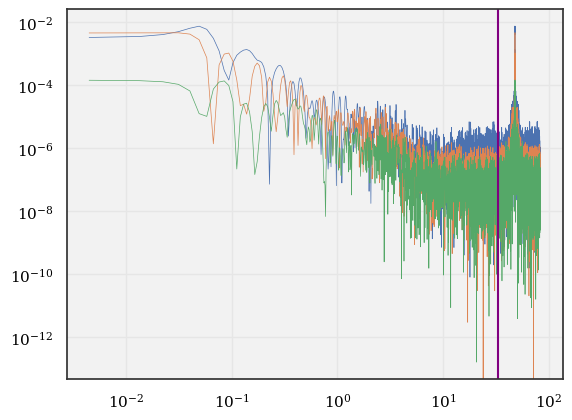

In [148]:
plt.loglog(epsf_freq, epsf_powr, lw=0.5)
plt.loglog(aper_freq, aper_powr, lw=0.5)
plt.loglog(lst_freq, lst_powr, lw=0.5)
plt.axvline(33.2, c='purple')

In [10]:
def run_tglc(tic):
    """input TIC"""
    target = f'TIC {tic}'
    local_directory = f'tglc_outputs/{target}/'    # directory to save all files
    os.makedirs(local_directory, exist_ok=True)
    tglc_lc(target=target, local_directory=local_directory, size=90, save_aper=True, limit_mag=16, get_all_lc=False,
            first_sector_only=True, last_sector_only=False, sector=None, prior=None, transient=None)

    with open(f'{local_directory}source/source_{target}_sector_9.pkl', 'rb') as input_:
        source = pickle.load(input_)
        #print(f'sector = {source.sector}')
    epsf = np.load(f'{local_directory}epsf/epsf_{target}_sector_9.npy')

    mask = source.tic['TIC'] == tic
    target_gaiadr3_source = source.tic[mask]['dr3_source_id'].value

    epsf_images = epsf[:, :23**2].reshape(-1, 23, 23)
    ffi_images = source.flux[:,34:57,34:57]

    return ffi_images, epsf_images, target_gaiadr3_source

In [4]:
def find_aperture_mask(ffis, epsfs):

    n = int(np.sqrt(epsfs.shape[1]))  # infer image size (e.g., 23)

    median_ffi = np.nanmedian(ffis, axis=0)
    median_psf = np.nanmedian(epsfs, axis=0)
    weighted_median_flux = median_ffi

    # Create x, y coordinate grids
    y, x = np.indices(weighted_median_flux.shape)  # both shape (n, n)

    # Flatten everything and stack into columns
    X = np.column_stack([x.flatten(), y.flatten(), weighted_median_flux.flatten() * median_psf.flatten()/max(median_psf.flatten())])

    # Clustering!
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import HDBSCAN
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clusterer = HDBSCAN(allow_single_cluster=True, min_cluster_size=4, min_samples=3)#, max_cluster_size=25)
    fit = clusterer.fit(X_scaled)
    labels = fit.labels_


    ny, nx = weighted_median_flux.shape
    center_idx = (ny // 2) * nx + (nx // 2)

    # Get the label of the central pixel
    central_label = labels[center_idx]

    # Create a mask for that cluster (True where the cluster matches the central pixel’s label)
    cluster_mask = (labels == central_label).reshape(weighted_median_flux.shape)
    
    # Label connected components (4-connectivity by default)
    labeled_array, num_features = label(cluster_mask, connectivity=1, return_num=True)
    
    if num_features == 0:
        new_mask = cluster_mask
    else:
        # Find the largest connected component
        component_sizes = np.bincount(labeled_array.ravel())[1:]  # Skip background (0)
        largest_component = np.argmax(component_sizes) + 1

    new_mask = labeled_array == largest_component

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(6, 6))

    # Show PSF image as background
    im = ax.imshow(median_psf, cmap='viridis', alpha=0.9)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Overlay hollow red squares for aperture pixels
    for y, x in zip(*np.where(new_mask)):
        rect = patches.Rectangle(
            (x - 0.5, y - 0.5),  # lower-left corner
            1, 1,                # width, height
            linewidth=1.5,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_title("HDBSCAN Aperture Overlay", fontsize=14)
    ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    plt.show()

    return new_mask

In [5]:
def square_aperture_like(mask, size=3):
    """Create a centered square aperture with the same centroid as mask."""
    ny, nx = mask.shape
    mask = np.zeros((ny, nx), dtype=bool)

    # Find central pixel
    cy, cx = ny // 2, nx // 2
    half = size // 2

    # Define box bounds (clipped to image edges)
    y_min = max(cy - half, 0)
    y_max = min(cy + half + 1, ny)
    x_min = max(cx - half, 0)
    x_max = min(cx + half + 1, nx)

    mask[y_min:y_max, x_min:x_max] = True
    return mask

In [6]:
def correct_lc(time, flux, background, psf_images, aperture):
    import lightkurve as lk
    from lightkurve.correctors import DesignMatrix
    from lightkurve.correctors import RegressionCorrector
    
    # Make an aperture mask and an uncorrected light curve
    aper = aperture
    uncorrected_lc = lk.LightCurve(time=time,flux=flux)

    # Make a design matrix and pass it to a linear regression corrector
    dm = DesignMatrix(background, name='regressors').pca(10).append_constant()
    rc = RegressionCorrector(uncorrected_lc)
    corrected_ffi_lc = rc.correct(dm)

    # Optional: Remove the scattered light, allowing for the large offset from scattered light
    corrected_ffi_lc = uncorrected_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)

    return corrected_ffi_lc

In [7]:
from astropy.convolution import Box1DKernel, convolve, Gaussian1DKernel, convolve_fft
from astropy.units import cds


def Gaussian_high_pass_filter(data, window_size):
    """
    Apply a Gaussian (boxcar four times) high-pass filter by subtracting a moving average

    Parameters:
    - data: array-like, the input signal
    - window_size: int, length of the moving average window

    Returns:
    - high_passed: np.ndarray, the high-pass filtered signal
    """
    
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("window_size must be a positive integer")

    # Boxcar filter (simple moving average)

    gauss = Gaussian1DKernel(window_size)
    smoothed = convolve(data, gauss, boundary='extend', normalize_kernel=True)
    

    high_passed = data - smoothed

    return high_passed

def HighPassFilter(lc, highpass_filter = 4, method = 'Flatten', normalize = True):
    if method == 'Flatten':
        # High-pass filter. Default filter width is 4 days (attenuates frequency below 3 microHz)
        window_length =  int(np.shape(lc)[0]/((lc.time.value[-1]-lc.time.value[0])/highpass_filter))
    
        window_length = window_length ## get rid of the dimensions and convert to an int
        if window_length % 2 == 0:
            window_length += 1
    
        lc_corr = lc.flatten(window_length)
        
        if normalize:
            lc_corr = lc_corr.normalize(unit = 'ppm')
    
    elif method == 'Gaussian':
        filter_width = int(np.shape(lc)[0]/((lc.time.value[-1]-lc.time.value[0])/highpass_filter))
        
        high_passed = Gaussian_high_pass_filter(lc.flux.value, window_size = filter_width)

        lc_dict = {'time': lc.time.value, 'flux': high_passed *1.e3* cds.ppm}
        
        lc_corr = lk.LightCurve(lc_dict)

    lc_final = lc_corr.remove_outliers(3)
    
    return lc_final

def PSD(lc, sector = None, numax_est = None, min_freq = 3, max_freq = 280, oversample = 5):
    
    psd = lc.to_periodogram(method='lombscargle', normalization='psd', maximum_frequency = max_freq, minimum_frequency = min_freq, oversample_factor = oversample)
    
    return psd

In [11]:
tic = 1008989
ffi_images, psf_images, gaia_id = run_tglc(tic)

Target: TIC 1008989
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0009-1-4      9      1   4
tess-s0036-1-4     36      1   4
tess-s0045-4-3     45      4   3
tess-s0046-3-3     46      3   3
tess-s0062-1-3     62      1   3
tess-s0072-4-3     72      4   3
tess-s0089-1-3     89      1   3
Only processing the first sector the target is observed in: Sector 9.
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0009-1-4      9      1   4
tess-s0036-1-4     36      1   4
tess-s0045-4-3     45      4   3
tess-s0046-3-3     46      3   3
tess-s0062-1-3     62      1   3
tess-s0072-4-3     72      4   3
tess-s0089-1-3     89      1   3
Loaded ffi_cut from directory. 
Already in sector 9.
Loaded ePSF TIC 1008989 from directory. 


Fitting lc: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


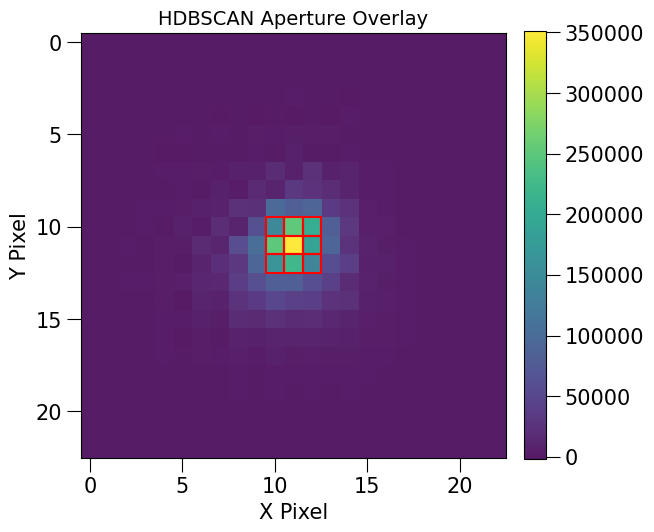

In [12]:
aperture = find_aperture_mask(ffi_images, psf_images)

In [14]:
from astropy.io import fits
hdul_s007 = fits.open(f'tglc_outputs/TIC {tic}/lc/hlsp_tglc_tess_ffi_gaiaid-{gaia_id[0]}-s0009-cam1-ccd4_tess_v2_llc.fits')
hdul_s007.info()
q_07 = [a and b for a, b in zip(list(hdul_s007[1].data['TESS_flags'] == 0),
                                list(hdul_s007[1].data['TGLC_flags'] == 0))]
time = hdul_s007[1].data['time'][q_07]

Filename: tglc_outputs/TIC 1008989/lc/hlsp_tglc_tess_ffi_gaiaid-3789639280952610304-s0009-cam1-ccd4_tess_v2_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 1154)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   1154R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   


In [15]:
raw_flux_cls = np.sum(psf_images[:, aperture], axis=1)[q_07]
raw_bkg_cls = np.sum(psf_images[:, ~aperture], axis=1)[q_07]
#raw_lc_cls = pd.DataFrame({'time':time.copy(), 'flux':raw_flux_cls.copy()})

mask_3x3 = square_aperture_like(aperture, size=3)
raw_flux_3x3 = np.sum(psf_images[:, mask_3x3], axis=1)[q_07]
raw_bkg_3x3 = np.sum(psf_images[:, ~aperture], axis=1)[q_07]

#raw_lc_3x3 = pd.DataFrame({'time':time.copy(), 'flux':raw_flux_3x3.copy()})


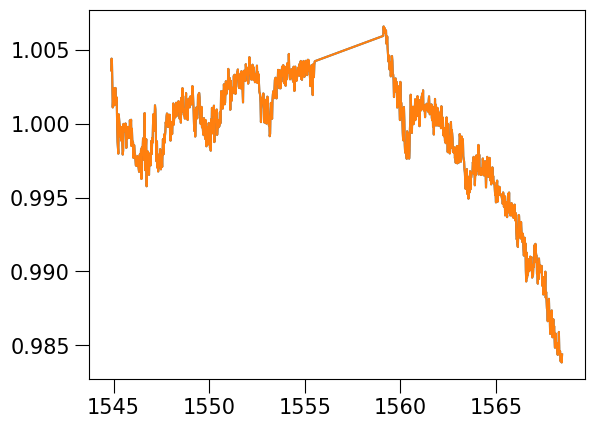

In [16]:
plt.plot(time, raw_flux_cls/np.median(raw_flux_cls))
plt.plot(time, raw_flux_3x3/np.median(raw_flux_3x3))

In [17]:
corr_lc_cls = correct_lc(time, raw_flux_cls, raw_bkg_cls, psf_images, aperture)
corr_lc_3x3 = correct_lc(time, raw_flux_3x3, raw_bkg_3x3, psf_images, mask_3x3)

<Axes: xlabel='Time [JD]', ylabel='Flux'>

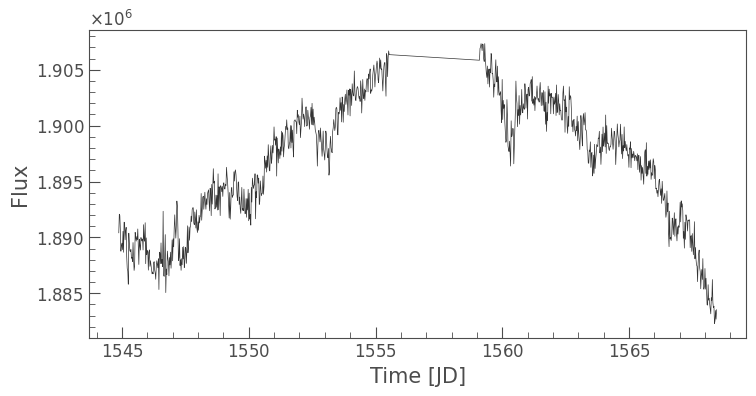

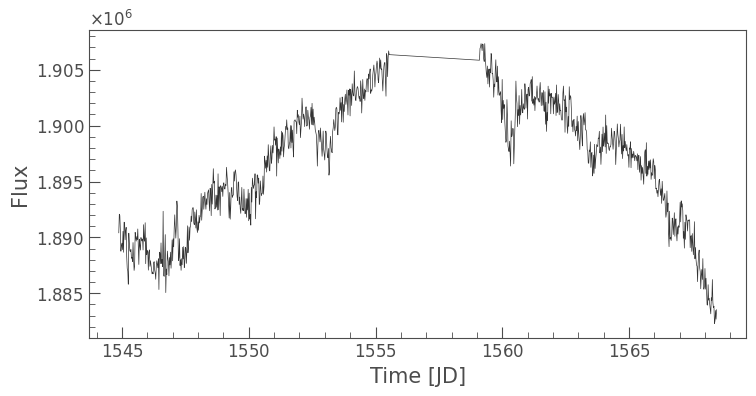

In [18]:
corr_lc_cls.plot()
corr_lc_3x3.plot()

In [19]:
corr_lc_cls_hp = HighPassFilter(corr_lc_cls, highpass_filter = 4, method = 'Flatten', normalize = True)
corr_lc_3x3_hp = HighPassFilter(corr_lc_3x3, highpass_filter = 4, method = 'Flatten', normalize = True)

<Axes: xlabel='Time [JD]', ylabel='Normalized Flux'>

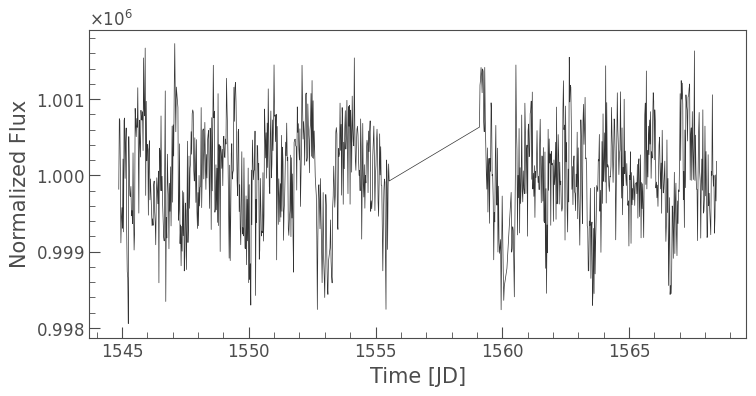

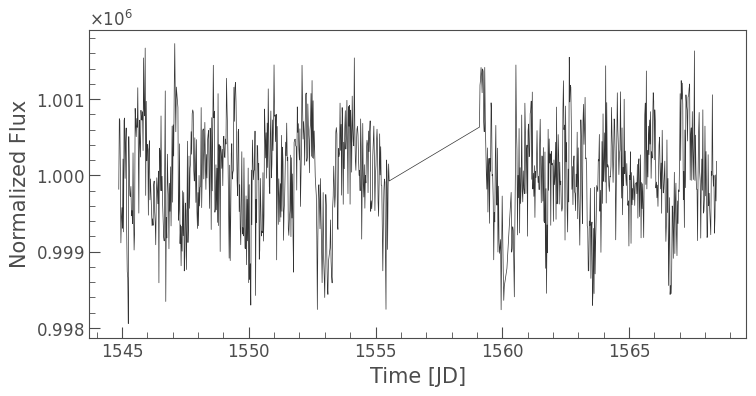

In [20]:
corr_lc_cls_hp.plot()
corr_lc_3x3_hp.plot()

In [21]:
psd_cls = PSD(corr_lc_cls_hp, sector = None, numax_est = None, min_freq = 3, max_freq = 280, oversample = 1)
psd_3x3 = PSD(corr_lc_3x3_hp, sector = None, numax_est = None, min_freq = 3, max_freq = 280, oversample = 1)

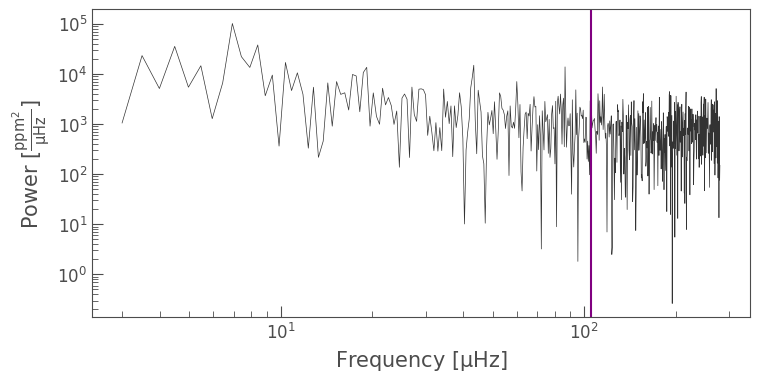

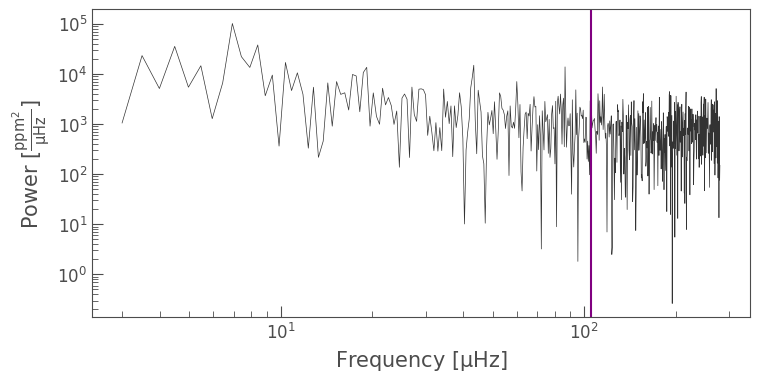

In [23]:
psd_cls.plot(scale='log')
plt.axvline(105.5, c='purple')
plt.show()
psd_3x3.plot(scale='log')
plt.axvline(105.5, c='purple')

plt.show()

In [ ]:
tglc_otputs/TIC 9423/lc/hlsp_tglc_tess_ffi_gaiaid-6223541344302981120-s0011-cam1-ccd4_tess_v2_llc.fits
tglc_otputs/TIC 9423/lc/hlsp_tglc_tess_ffi_gaiaid-6223541344302981120-s0011-cam1-ccd4_tess_v2_llc.fits